<a href="https://colab.research.google.com/github/raviintechis/Ravi_Rain_Prediction/blob/main/Ravi_Rain_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score
import pickle

import warnings
warnings.filterwarnings('ignore')

In [29]:
weather_data = pd.read_csv("/content/forecast_data.csv")
weather_data.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,state,city
0,1634236200,2021-10-15 00:00,23.2,73.8,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.3,6.8,41,NE,1006.0,29.69,0.0,0.0,67,5,25.1,77.2,23.2,73.8,25.1,77.2,16.7,62.1,0,0,0,0,10.0,6.0,8.9,14.4,Andhra Pradesh,Amaravati
1,1634239800,2021-10-15 01:00,23.0,73.3,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.1,6.6,34,NE,1005.0,29.68,0.0,0.0,67,6,25.0,77.0,23.0,73.3,25.0,77.0,16.5,61.8,0,0,0,0,10.0,6.0,8.6,13.9,Andhra Pradesh,Amaravati
2,1634243400,2021-10-15 02:00,22.7,72.9,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",4.0,6.4,28,NNE,1005.0,29.67,0.0,0.0,67,8,24.9,76.8,22.7,72.9,24.9,76.8,16.4,61.5,0,0,0,0,10.0,6.0,8.4,13.4,Andhra Pradesh,Amaravati
3,1634247000,2021-10-15 03:00,22.5,72.5,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",3.8,6.1,22,NNE,1005.0,29.66,0.0,0.0,67,10,24.8,76.6,22.5,72.5,24.8,76.6,16.2,61.2,0,0,0,0,10.0,6.0,8.1,13.0,Andhra Pradesh,Amaravati
4,1634250600,2021-10-15 04:00,22.3,72.1,0,"{'text': 'Clear', 'icon': '//cdn.weatherapi.co...",3.7,6.0,23,NNE,1005.0,29.68,0.0,0.0,68,10,24.7,76.5,22.3,72.1,24.7,76.5,16.1,61.0,0,0,0,0,10.0,6.0,7.9,12.7,Andhra Pradesh,Amaravati


In [30]:
weather_data.shape

(29568, 34)

In [31]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_epoch      29568 non-null  int64  
 1   time            29568 non-null  object 
 2   temp_c          29568 non-null  float64
 3   temp_f          29568 non-null  float64
 4   is_day          29568 non-null  int64  
 5   condition       29568 non-null  object 
 6   wind_mph        29568 non-null  float64
 7   wind_kph        29568 non-null  float64
 8   wind_degree     29568 non-null  int64  
 9   wind_dir        29568 non-null  object 
 10  pressure_mb     29568 non-null  float64
 11  pressure_in     29568 non-null  float64
 12  precip_mm       29568 non-null  float64
 13  precip_in       29568 non-null  float64
 14  humidity        29568 non-null  int64  
 15  cloud           29568 non-null  int64  
 16  feelslike_c     29568 non-null  float64
 17  feelslike_f     29568 non-null 

In [32]:
weather_data.isnull().sum()

time_epoch        0
time              0
temp_c            0
temp_f            0
is_day            0
condition         0
wind_mph          0
wind_kph          0
wind_degree       0
wind_dir          0
pressure_mb       0
pressure_in       0
precip_mm         0
precip_in         0
humidity          0
cloud             0
feelslike_c       0
feelslike_f       0
windchill_c       0
windchill_f       0
heatindex_c       0
heatindex_f       0
dewpoint_c        0
dewpoint_f        0
will_it_rain      0
chance_of_rain    0
will_it_snow      0
chance_of_snow    0
vis_km            0
vis_miles         0
gust_mph          0
gust_kph          0
state             0
city              0
dtype: int64

In [33]:
weather_data.describe()

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph
count,2.956800e+04,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.000000,29568.0,29568.0,29568.000000,29568.000000,29568.000000,29568.000000
mean,1.634580e+09,25.152307,77.273793,0.477070,5.077486,8.169619,177.818452,1008.341112,29.775472,0.101552,0.003860,71.848755,42.816795,27.037585,80.667539,25.138961,77.249736,27.180685,80.925115,18.650761,65.571567,0.089928,12.155202,0.0,0.0,9.263460,5.488433,7.947697,12.791274
std,1.995536e+05,4.797702,8.635461,0.499482,2.847123,4.582337,103.545331,3.438631,0.101294,0.406883,0.016102,21.549604,34.414168,5.855531,10.540115,4.846674,8.723718,5.707867,10.274241,5.715956,10.288746,0.286084,24.999675,0.0,0.0,1.986747,1.281815,4.141102,6.665310
min,1.634227e+09,1.500000,34.700000,0.000000,0.000000,0.000000,0.000000,999.000000,29.490000,0.000000,0.000000,5.000000,0.000000,-0.500000,31.100000,-0.500000,31.100000,1.500000,34.700000,-8.200000,17.200000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.634408e+09,22.500000,72.600000,0.000000,3.100000,4.900000,83.000000,1006.000000,29.690000,0.000000,0.000000,59.000000,7.000000,24.700000,76.400000,22.500000,72.600000,24.700000,76.400000,16.000000,60.800000,0.000000,0.000000,0.0,0.0,10.000000,6.000000,4.900000,7.900000
50%,1.634580e+09,25.100000,77.200000,0.000000,4.500000,7.200000,174.000000,1008.000000,29.780000,0.000000,0.000000,77.000000,41.000000,27.100000,80.800000,25.100000,77.200000,27.100000,80.800000,20.400000,68.700000,0.000000,0.000000,0.0,0.0,10.000000,6.000000,7.300000,11.800000
75%,1.634753e+09,28.100000,82.600000,1.000000,6.500000,10.400000,273.000000,1011.000000,29.850000,0.040000,0.000000,89.000000,74.000000,30.700000,87.200000,28.100000,82.600000,30.700000,87.200000,22.900000,73.300000,0.000000,3.000000,0.0,0.0,10.000000,6.000000,10.400000,16.700000
max,1.634958e+09,39.300000,102.700000,1.000000,22.400000,36.000000,359.000000,1021.000000,30.160000,20.930000,0.820000,100.000000,100.000000,53.100000,127.600000,39.300000,102.700000,53.100000,127.600000,30.200000,86.400000,1.000000,94.000000,0.0,0.0,10.000000,6.000000,32.700000,52.600000


In [34]:
weather_data_num=weather_data.select_dtypes(include=['float64','int64'])
weather_data_num.head()

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph
0,1634236200,23.2,73.8,0,4.3,6.8,41,1006.0,29.69,0.0,0.0,67,5,25.1,77.2,23.2,73.8,25.1,77.2,16.7,62.1,0,0,0,0,10.0,6.0,8.9,14.4
1,1634239800,23.0,73.3,0,4.1,6.6,34,1005.0,29.68,0.0,0.0,67,6,25.0,77.0,23.0,73.3,25.0,77.0,16.5,61.8,0,0,0,0,10.0,6.0,8.6,13.9
2,1634243400,22.7,72.9,0,4.0,6.4,28,1005.0,29.67,0.0,0.0,67,8,24.9,76.8,22.7,72.9,24.9,76.8,16.4,61.5,0,0,0,0,10.0,6.0,8.4,13.4
3,1634247000,22.5,72.5,0,3.8,6.1,22,1005.0,29.66,0.0,0.0,67,10,24.8,76.6,22.5,72.5,24.8,76.6,16.2,61.2,0,0,0,0,10.0,6.0,8.1,13.0
4,1634250600,22.3,72.1,0,3.7,6.0,23,1005.0,29.68,0.0,0.0,68,10,24.7,76.5,22.3,72.1,24.7,76.5,16.1,61.0,0,0,0,0,10.0,6.0,7.9,12.7


In [35]:
weather_data_num.shape

(29568, 29)

In [36]:
weather_data_corr=weather_data_num.corr()
weather_data_corr

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph
time_epoch,1.000000,-0.131612,-0.131587,0.002710,0.060042,0.060070,0.259429,0.686185,0.688035,0.010479,0.011205,0.080260,-0.028581,-0.146788,-0.146817,-0.129927,-0.129915,-0.147706,-0.147726,-0.016001,-0.016020,0.002626,0.024158,NaN,NaN,-0.097647,-0.094283,0.042777,0.042709
temp_c,-0.131612,1.000000,0.999984,0.448089,0.267645,0.267521,0.102912,-0.459322,-0.460847,-0.106922,-0.104503,-0.524848,-0.238334,0.955068,0.955063,0.999628,0.999612,0.953677,0.953675,0.213842,0.213819,-0.040835,-0.145782,NaN,NaN,0.279052,0.285306,0.068385,0.068239
temp_f,-0.131587,0.999984,1.000000,0.448129,0.267647,0.267522,0.102901,-0.459302,-0.460834,-0.106886,-0.104473,-0.524861,-0.238317,0.955067,0.955068,0.999614,0.999629,0.953672,0.953675,0.213827,0.213805,-0.040851,-0.145759,NaN,NaN,0.279020,0.285269,0.068385,0.068240
is_day,0.002710,0.448089,0.448129,1.000000,0.194623,0.194676,0.065103,-0.032703,-0.033080,-0.014205,-0.013743,-0.259619,-0.006559,0.446888,0.446896,0.444640,0.444672,0.443929,0.443937,0.096156,0.096161,0.019283,0.005468,NaN,NaN,0.127725,0.121825,-0.078826,-0.078925
wind_mph,0.060042,0.267645,0.267647,0.194623,1.000000,0.999929,0.127415,-0.108492,-0.109661,0.051496,0.051744,-0.149224,-0.037371,0.269561,0.269543,0.264273,0.264274,0.270224,0.270206,0.074075,0.074057,0.015279,-0.020026,NaN,NaN,0.125693,0.125958,0.908919,0.908837
wind_kph,0.060070,0.267521,0.267522,0.194676,0.999929,1.000000,0.127490,-0.108387,-0.109553,0.051545,0.051810,-0.149095,-0.037261,0.269468,0.269451,0.264143,0.264145,0.270137,0.270119,0.074132,0.074113,0.015327,-0.019899,NaN,NaN,0.125478,0.125739,0.908950,0.908867
wind_degree,0.259429,0.102912,0.102901,0.065103,0.127415,0.127490,1.000000,0.110109,0.110502,-0.046307,-0.045024,-0.100022,-0.143494,0.068485,0.068462,0.104093,0.104079,0.070253,0.070233,-0.027981,-0.027987,-0.027434,-0.059690,NaN,NaN,0.043545,0.050117,0.103274,0.103172
pressure_mb,0.686185,-0.459322,-0.459302,-0.032703,-0.108492,-0.108387,0.110109,1.000000,0.995692,-0.027494,-0.028503,0.132803,-0.035273,-0.493311,-0.493317,-0.459978,-0.459953,-0.496050,-0.496068,-0.213843,-0.213826,-0.071719,-0.020073,NaN,NaN,-0.123383,-0.120051,-0.100758,-0.100777
pressure_in,0.688035,-0.460847,-0.460834,-0.033080,-0.109661,-0.109553,0.110502,0.995692,1.000000,-0.028393,-0.029435,0.133520,-0.035140,-0.494833,-0.494842,-0.461488,-0.461472,-0.497652,-0.497671,-0.214046,-0.214035,-0.069980,-0.017543,NaN,NaN,-0.124140,-0.120939,-0.102048,-0.102070
precip_mm,0.010479,-0.106922,-0.106886,-0.014205,0.051496,0.051545,-0.046307,-0.027494,-0.028393,1.000000,0.995183,0.233209,0.316297,-0.068948,-0.068945,-0.105335,-0.105295,-0.072235,-0.072225,0.129642,0.129626,0.123182,0.239524,NaN,NaN,-0.169868,-0.185439,0.061433,0.061402


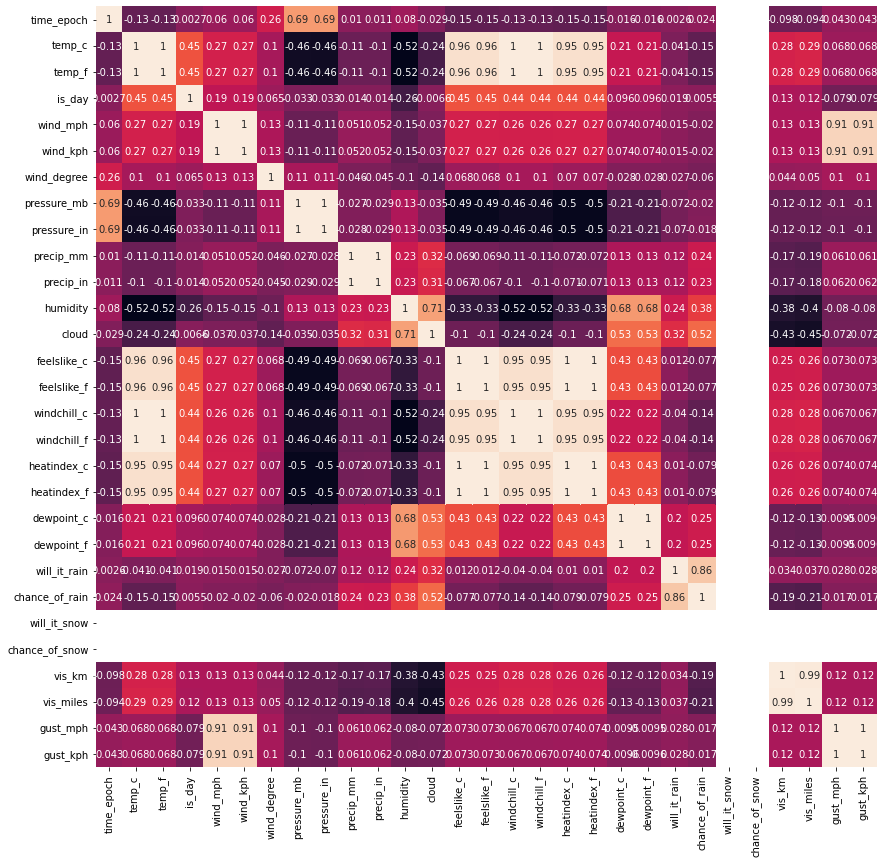

In [37]:
corr_matrix = weather_data.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.show()

In [38]:
# Encode the categorical text values
cols_to_encode = ['condition', 'wind_dir', 'state', 'city']
for col in cols_to_encode:
  le = LabelEncoder()
  weather_data[col] = le.fit_transform(weather_data[col])

In [39]:
weather_data.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,state,city
0,1634236200,2021-10-15 00:00,23.2,73.8,0,0,4.3,6.8,41,4,1006.0,29.69,0.0,0.0,67,5,25.1,77.2,23.2,73.8,25.1,77.2,16.7,62.1,0,0,0,0,10.0,6.0,8.9,14.4,0,7
1,1634239800,2021-10-15 01:00,23.0,73.3,0,0,4.1,6.6,34,4,1005.0,29.68,0.0,0.0,67,6,25.0,77.0,23.0,73.3,25.0,77.0,16.5,61.8,0,0,0,0,10.0,6.0,8.6,13.9,0,7
2,1634243400,2021-10-15 02:00,22.7,72.9,0,0,4.0,6.4,28,5,1005.0,29.67,0.0,0.0,67,8,24.9,76.8,22.7,72.9,24.9,76.8,16.4,61.5,0,0,0,0,10.0,6.0,8.4,13.4,0,7
3,1634247000,2021-10-15 03:00,22.5,72.5,0,0,3.8,6.1,22,5,1005.0,29.66,0.0,0.0,67,10,24.8,76.6,22.5,72.5,24.8,76.6,16.2,61.2,0,0,0,0,10.0,6.0,8.1,13.0,0,7
4,1634250600,2021-10-15 04:00,22.3,72.1,0,0,3.7,6.0,23,5,1005.0,29.68,0.0,0.0,68,10,24.7,76.5,22.3,72.1,24.7,76.5,16.1,61.0,0,0,0,0,10.0,6.0,7.9,12.7,0,7


In [40]:
# drop the time column
weather_data.drop('time', axis=1, inplace=True)

In [41]:
# Scale the data
X = weather_data.drop('will_it_rain', axis=1)
y = weather_data['will_it_rain']

X_columns = X.columns
ss = StandardScaler()
X_scaled_arr = ss.fit_transform(X)

# Create a new dataframe called X_scaled
X_scaled = pd.DataFrame(X_scaled_arr, columns=X_columns)

In [42]:
X_scaled.head()

,time_epoch,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,windchill_c,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,state,city
0,-1.723372,-0.406932,-0.402277,-0.955145,-1.335351,-0.273082,-0.298896,-1.321361,-0.682993,-0.680838,-0.843813,-0.249591,-0.239724,-0.225008,-1.098891,-0.330904,-0.328991,-0.400067,-0.395450,-0.364536,-0.362575,-0.341289,-0.337420,-0.486223,0.0,0.0,0.370733,0.399102,0.229968,0.241362,-1.690892,-1.544443
1,-1.705332,-0.448620,-0.460179,-0.955145,-1.335351,-0.343330,-0.342543,-1.388965,-0.682993,-0.971657,-0.942538,-0.249591,-0.239724,-0.225008,-1.069833,-0.347982,-0.347966,-0.441333,-0.452766,-0.382056,-0.382041,-0.376280,-0.366578,-0.486223,0.0,0.0,0.370733,0.399102,0.157522,0.166346,-1.690892,-1.544443
2,-1.687291,-0.511151,-0.506501,-0.955145,-1.335351,-0.378454,-0.386189,-1.446912,-0.478701,-0.971657,-1.041262,-0.249591,-0.239724,-0.225008,-1.011717,-0.365060,-0.366941,-0.503232,-0.498619,-0.399576,-0.401507,-0.393775,-0.395737,-0.486223,0.0,0.0,0.370733,0.399102,0.109225,0.091329,-1.690892,-1.544443
3,-1.669250,-0.552838,-0.552822,-0.955145,-1.335351,-0.448701,-0.451659,-1.504859,-0.478701,-0.971657,-1.139986,-0.249591,-0.239724,-0.225008,-0.953600,-0.382138,-0.385917,-0.544498,-0.544472,-0.417095,-0.420974,-0.428765,-0.424895,-0.486223,0.0,0.0,0.370733,0.399102,0.036779,0.031316,-1.690892,-1.544443
4,-1.651210,-0.594525,-0.599144,-0.955145,-1.335351,-0.483825,-0.473482,-1.495201,-0.478701,-0.971657,-0.942538,-0.249591,-0.239724,-0.178603,-0.953600,-0.399216,-0.395405,-0.585764,-0.590324,-0.434615,-0.430707,-0.446260,-0.444334,-0.486223,0.0,0.0,0.370733,0.399102,-0.011518,-0.013694,-1.690892,-1.544443


In [43]:
X_scaled.shape

(29568, 32)

In [44]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [45]:
#Fitting the model
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
lr=model.score(X_test,y_test)
lr

0.9994927291173487

In [46]:
print('Accuracy =' ,round(model.score(X_test,y_test)*100,2),'%')

Accuracy = 99.95 %


In [47]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]))
print(metrics.classification_report(y_test, y_pred, labels = [0,1]))

[[5358    3]
 [   0  553]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5361
           1       0.99      1.00      1.00       553

    accuracy                           1.00      5914
   macro avg       1.00      1.00      1.00      5914
weighted avg       1.00      1.00      1.00      5914



In [53]:
# XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred=xgb_clf.predict(X_test)
xgbclf=xgb_clf.score(X_test,y_test)
xgbclf

1.0